# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

C:\Users\hp\anaconda3\envs\sdv_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                    #    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,1,1)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
# from utils import get_mnist_data
# train, test = get_mnist_data(train_transforms, test_transforms)
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.05
from model import Model_6



# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_6().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
         GroupNorm-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5            [-1, 8, 32, 32]             576
              ReLU-6            [-1, 8, 32, 32]               0
         GroupNorm-7            [-1, 8, 32, 32]              16
           Dropout-8            [-1, 8, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             576
             ReLU-10            [-1, 8, 32, 32]               0
        GroupNorm-11            [-1, 8, 32, 32]              16
          Dropout-12            [-1, 8, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]             128
        MaxPool2d-14           [-1

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [7]:
# from utils import train, test



from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Model_6().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.3817564249038696 Batch_id=390 Accuracy=31.97: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.90it/s]



Test set: Average loss: 1.5245, Accuracy: 4335/10000 (43.35%)

EPOCH: 1


Loss=1.5740517377853394 Batch_id=390 Accuracy=45.93: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.93it/s]



Test set: Average loss: 1.3338, Accuracy: 5141/10000 (51.41%)

EPOCH: 2


Loss=1.3907164335250854 Batch_id=390 Accuracy=52.39: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.57it/s]



Test set: Average loss: 1.2174, Accuracy: 5636/10000 (56.36%)

EPOCH: 3


Loss=1.565395712852478 Batch_id=390 Accuracy=56.68: 100%|████████████████████████████| 391/391 [00:14<00:00, 26.34it/s]



Test set: Average loss: 1.1872, Accuracy: 5794/10000 (57.94%)

EPOCH: 4


Loss=1.3065450191497803 Batch_id=390 Accuracy=59.22: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.61it/s]



Test set: Average loss: 1.0439, Accuracy: 6273/10000 (62.73%)

EPOCH: 5


Loss=1.1046900749206543 Batch_id=390 Accuracy=65.15: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.94it/s]



Test set: Average loss: 0.9369, Accuracy: 6672/10000 (66.72%)

EPOCH: 6


Loss=0.9476562738418579 Batch_id=390 Accuracy=65.74: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.38it/s]



Test set: Average loss: 0.9278, Accuracy: 6690/10000 (66.90%)

EPOCH: 7


Loss=0.7577425241470337 Batch_id=390 Accuracy=66.34: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.77it/s]



Test set: Average loss: 0.9192, Accuracy: 6723/10000 (67.23%)

EPOCH: 8


Loss=0.7645347714424133 Batch_id=390 Accuracy=66.85: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.09it/s]



Test set: Average loss: 0.9338, Accuracy: 6667/10000 (66.67%)

EPOCH: 9


Loss=0.9259428977966309 Batch_id=390 Accuracy=67.10: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.23it/s]



Test set: Average loss: 0.9129, Accuracy: 6755/10000 (67.55%)

EPOCH: 10


Loss=0.8021326065063477 Batch_id=390 Accuracy=68.20: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.51it/s]



Test set: Average loss: 0.8975, Accuracy: 6839/10000 (68.39%)

EPOCH: 11


Loss=0.9042328596115112 Batch_id=390 Accuracy=68.00: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.32it/s]



Test set: Average loss: 0.8945, Accuracy: 6840/10000 (68.40%)

EPOCH: 12


Loss=0.8884531259536743 Batch_id=390 Accuracy=68.36: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.73it/s]



Test set: Average loss: 0.8947, Accuracy: 6838/10000 (68.38%)

EPOCH: 13


Loss=0.8556919097900391 Batch_id=390 Accuracy=68.41: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.63it/s]



Test set: Average loss: 0.8924, Accuracy: 6836/10000 (68.36%)

EPOCH: 14


Loss=1.0513851642608643 Batch_id=390 Accuracy=68.23: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.15it/s]



Test set: Average loss: 0.8910, Accuracy: 6841/10000 (68.41%)

EPOCH: 15


Loss=1.0781081914901733 Batch_id=390 Accuracy=68.40: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.73it/s]



Test set: Average loss: 0.8902, Accuracy: 6846/10000 (68.46%)

EPOCH: 16


Loss=0.9532464742660522 Batch_id=390 Accuracy=68.38: 100%|███████████████████████████| 391/391 [00:15<00:00, 26.01it/s]



Test set: Average loss: 0.8896, Accuracy: 6855/10000 (68.55%)

EPOCH: 17


Loss=0.7385964393615723 Batch_id=390 Accuracy=68.49: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.96it/s]



Test set: Average loss: 0.8894, Accuracy: 6849/10000 (68.49%)

EPOCH: 18


Loss=0.7855324745178223 Batch_id=390 Accuracy=68.57: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.50it/s]



Test set: Average loss: 0.8891, Accuracy: 6857/10000 (68.57%)

EPOCH: 19


Loss=0.8619359731674194 Batch_id=390 Accuracy=68.44: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.93it/s]



Test set: Average loss: 0.8898, Accuracy: 6841/10000 (68.41%)



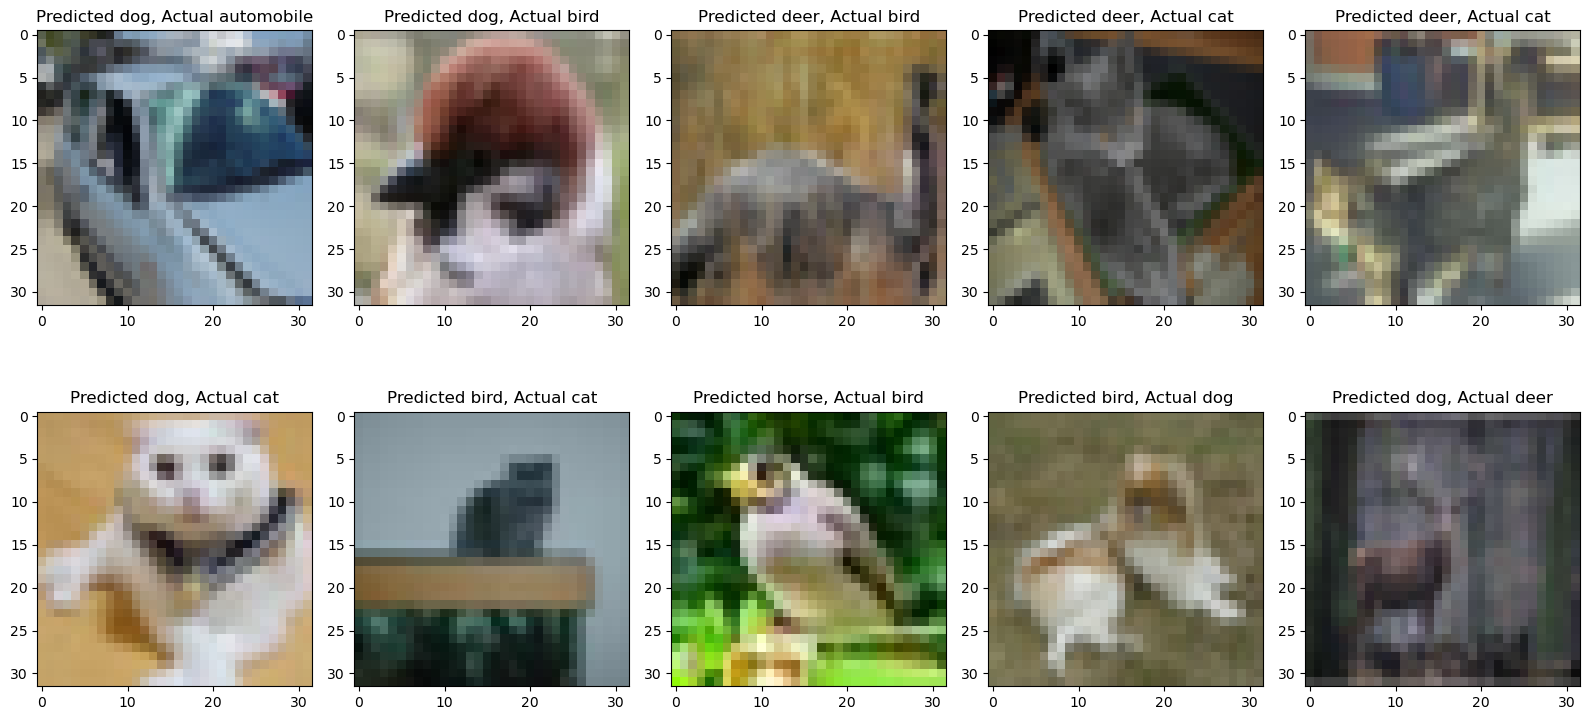

In [11]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_incorrect_images(model,test_loader,n=10):
  incorrect_images = []
  predicted_labels = []
  correct_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect_items = pred.ne(target.view_as(pred))
    incorrect_indices = incorrect_items.view(-1).nonzero().view(-1)
    predicted_labels.extend([item.item() for item in pred[incorrect_indices[:n-len(incorrect_images)]]])
    correct_labels.extend([item.item() for item in target.view_as(pred)[incorrect_indices[:n-len(incorrect_images)]]])
    incorrect_images.extend([item for item in data[incorrect_indices[:n-len(incorrect_images)]]])
    if len(incorrect_images)==n:
      break
  return incorrect_images,predicted_labels,correct_labels

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img
  npimg = np.clip(npimg, 0, 1)  # Add this line to clip the values
  return np.transpose(npimg, (1, 2, 0))  # Convert from Tensor image

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

incorrect_images,predicted_labels,correct_labels = get_incorrect_images(model,test_loader,n=10)

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    ax.imshow(imshow(image))  # Display the image
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()